<a href="https://colab.research.google.com/github/BingniQ/Skeleton-based-fall-detection/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import os
import scipy
from scipy import linalg
import random
import math
import h5py
import theano
import keras
from theano import tensor as T
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional, \
    GRU, SimpleRNN, Input, SpatialDropout1D, Reshape, Permute, merge, Lambda
from keras.layers.merge import Add, Concatenate, Maximum
from keras.layers.convolutional import Convolution2D,Convolution3D
from keras.layers.pooling import MaxPooling1D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras.optimizers import RMSprop,SGD,Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.engine.topology import Layer
from keras.regularizers import l2, l1
from keras.constraints import maxnorm, unitnorm
import tensorflow as tf

Using TensorFlow backend.


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 100, 25, 3)        0         
_________________________________________________________________
reshape_21 (Reshape)         (None, 100, 75)           0         
_________________________________________________________________
spatial_dropout1d_60 (Spatia (None, 100, 75)           0         
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 100, 1024)         2408448   
_________________________________________________________________
spatial_dropout1d_61 (Spatia (None, 100, 1024)         0         
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 100, 1024)         6295552   
_________________________________________________________________
spatial_dropout1d_62 (Spatia (None, 100, 1024)         0         
__________

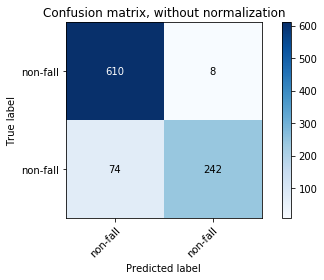

Normalized confusion matrix
[[0.99 0.01]
 [0.23 0.77]]


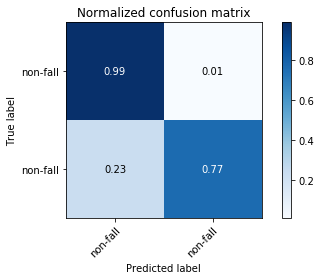

In [0]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def init_mean1(shape, dtype=None, name=None):
    value = np.array([0,0,-1.0/4,0,-1.0/4,  0,0,0,-1.0/4,0,  0,0,0,0,0,  0,0,0,0,0,  -1.0/4,0,0,0,0 ])
    value = np.reshape(value, shape)
    return value
    
def init_mean2(shape, dtype=None, name=None):
    value = np.array([-1.0/4,-1.0/4,0,0,0,  0,0,0,0,0,  0,0,-1.0/4,0,0,  0,-1.0/4,0,0,0,  0,0,0,0,0 ])
    value = np.reshape(value, shape)
    return value
    
def rand_rotate_matrix(shape, dtype=None, name=None, angle1=-90, angle2=90, s1=0.5, s2=1.5):
    random.random()
    agx = random.uniform(angle1, angle2)  # do not use randint
    agy = random.uniform(angle1, angle2)
    s = random.uniform(s1, s2)
    agx = math.radians(agx)
    agy = math.radians(agy)
    Rx = np.asarray([[1,0,0], [0,math.cos(agx),math.sin(agx)], [0, -math.sin(agx),math.cos(agx)]])
    Ry = np.asarray([[math.cos(agy), 0, -math.sin(agy)], [0,1,0], [math.sin(agy), 0, math.cos(agy)]])
    Ss = np.asarray([[s,0,0],[0,s,0],[0,0,s]])
    value = np.dot(Ry,np.dot(Rx,Ss))
    value = np.reshape(value, shape)
    return value
    
def rotate_skeleton_given_coord(skeleton, new_coord):
    # angle = (angle_x, angle_y, angle_z ), radian
    # notice: rotation matrix is a little different from definition above
    assert(skeleton.shape[-1] ==3 )
    org_shape = skeleton.shape
    # notice: transform is necessary
    skeleton0 = np.dot(skeleton.reshape((-1,3)),  new_coord.T )
    return skeleton0.reshape(org_shape)

def rand_rotate_matrix_symbol(angle=90, ss=0.5):
    srs = T.shared_randomstreams.RandomStreams()
    # np.pi / 180 *
    agx =  (srs.uniform()*(2*angle) - angle)*np.pi/180
    agy =  (srs.uniform()*(2*angle) - angle)*np.pi/180
    # s = srs.uniform() + ss
    Rx = T.stack(1,0,0, 0,T.cos(agx), T.sin(agx), 0, -T.sin(agx),T.cos(agx)).reshape((3,3))
    Ry = T.stack(T.cos(agy), 0, -T.sin(agy),  0,1,0,  T.sin(agy), 0, T.cos(agy)).reshape((3,3))
    # Ss = T.stack(s,0,0, 0,s,0, 0,0,s).reshape((3,3))
    # value = theano.dot(Ry, theano.dot(Rx, Ss))
    value = theano.dot(Ry, Rx)
    return value
    
class TransformLayer(Layer):
    def __init__(self, **kwargs):
        super(TransformLayer, self).__init__(**kwargs)
        
    def call(self, x, training=None):
        # return K.in_train_phase(K.dot(x, rand_rotate_matrix_symbol()), x, training=training)
        return K.in_train_phase(T.concatenate([K.dot(x[:,:,:,0:3], rand_rotate_matrix_symbol()), x[:,:,:,3:6] ], axis=3), x, training=training)
        
    def compute_output_shape(self, input_shape):
        return input_shape

class construct_model(object):
    def __init__(self, param, dim_point=3, num_joints=25, num_class=2):
        self._param = param
        self._dim_point = dim_point
        self._num_joints = num_joints
        self._num_class = num_class
        
    def group_person_list(self, list_file):
        name_list = [line.strip() for line in open(list_file, 'r').readlines()]
        vdname_list = [line[0:line.index('.skeleton')] for line in name_list ]
        label_list = [(int(name[17:20])-1) for name in name_list]
        idx_per = []
        group_list = []
        for idx, name in enumerate(name_list):
            vdname = vdname_list[idx]
            if idx == len(name_list)-1:
                last_vdname = ''
            else:
                last_vdname = vdname_list[idx+1]
            if vdname != last_vdname:
                idx_per.append(idx)
                # there exist samples with 3 skeletons, to check standard deviation
                # print len(idx_per), idx_per
                group_list.append(idx_per)
                # print [label_list[temp] for temp in idx_per]
                idx_per = []
            else:
                idx_per.append(idx)
        return group_list
        
    def spatial_diff(self, skeleton):
        assert(skeleton.shape[2] == 3), ' input must be skeleton array'
        fidx = [1, 1, 21, 3,    21, 5,6,7,   21,9,10,11,   1,13,14,15,   1, 17,18,19,  2,8,8,12,12 ]
        assert(len(fidx) == skeleton.shape[1] )
        return skeleton[:,np.array(fidx)-1 ] - skeleton
        # return np.concatenate((skeleton, skeleton[:,np.array(fidx)-1 ] - skeleton ), axis=-1)
        
    def spatial_cross(self, skeleton):
        assert(skeleton.shape[2] == 3), ' input must be skeleton array'
        if 0:
            fidx1 = [17,21,4,21,  6,5,6,22,  21,11,12,24,  1,13,16,14,  18,17,18,19,  5,8,8,  12,12]
            fidx2 = [13,1,21,3,  21,7,8,23,  10,9,10,25,  14,15,14,15,  1,19,20,18,  9,23,22, 25,24]
        else:
            fidx1 = [17,21,9,21,  6,5,6,22,  21,11,12,24,  2,1,13,14,  2,17,18,18,  2,8,8,  12,12]
            fidx2 = [13,1,21,3,  21,7,8,23,  10,9,10,25,  1,13,14,15,  1,1,17,19,  9,7,7, 11,11]
        skt1 = skeleton[:,np.array(fidx1)-1 ] - skeleton
        skt2 = skeleton[:,np.array(fidx2)-1 ] - skeleton
        return 100*(np.cross(skt1, skt2) )
        
    def load_sample_one_skeleton(self, h5_file, list_file, num_seq=100, ovr_num=50, spatil_diff=True ):
        '''
        To change overlap number
        '''
        name_list = [line.strip() for line in open(list_file, 'r').readlines()]
        vdname_list = [line[0:line.index('.skeleton')] for line in name_list ]
        label_list = [(int(name[17:20])-1) for name in name_list]
        # read angles
        # angle_list = [line.strip() for line in open(angle_file, 'r').readlines()]
        # angle_list_array = np.array([map(float, line.split()) for line in angle_list] )

        new_label_list=[]
        fall_number=0
        fall_number2=0
        for i in name_list:
            if "A043" in i:
                fall_number2=fall_number2+1

        for label in label_list:
            if label == 42:
                new_label_list.append(1)
                fall_number=fall_number+1
            else:
                new_label_list.append(0)

        print("load fall number",fall_number)
        print("load fall number from file",fall_number2)
        print("load total number",len(name_list))

        X = []
        Y = []
        vid_list = []
        with h5py.File(h5_file,'r') as hf:
            group_list = self.group_person_list(list_file)
            for idx_per in group_list:
                # labels in list are the same
                label_per = new_label_list[idx_per[0]]
                vdname = vdname_list[idx_per[0]]
                for idx in idx_per:
                    skeleton = np.asarray(hf.get(name_list[idx] ))
                    # skeleton[:,0] = 0

                    if spatil_diff:
                        skeleton = self.spatial_diff(skeleton)
                    else:
                        skeleton = self.spatial_cross(skeleton)
                        
                    if skeleton.shape[0] > num_seq:
                        start = 0
                        while start + num_seq < skeleton.shape[0]:
                            X.append(skeleton[start:start+num_seq])
                            Y.append(label_per)
                            vid_list.append(vdname)
                            start = start + ovr_num
                        X.append(skeleton[-num_seq:])
                        Y.append(label_per)
                        vid_list.append(vdname)
                    else:
                        skeleton = np.concatenate((np.zeros((num_seq-skeleton.shape[0], skeleton.shape[1], skeleton.shape[2])), skeleton), axis=0)
                        X.append(skeleton)
                        Y.append(label_per)
                        vid_list.append(vdname)
        X = np.asarray(X).astype(np.float32)
        Y = (np.asarray(Y)).astype(np.int32)
        return X, Y, vid_list
        
    def base_model(self, sub_mean=False, rotate=False):
        '''
        use stacked two layers as baseline, use stacked three layers later
        K.learning_phase()
        assert(self._dim_point == 3)
        data = Dense(self._dim_point, kernel_initializer=rand_rotate_matrix, trainable=False)(skt_input) 
        '''
        skt_input = Input(shape=(self._param['num_seq'], self._num_joints, self._dim_point) ) # To fix length of sequence
        data = skt_input
        if rotate:
            # assert(self._dim_point == 3)
            data = TransformLayer()(skt_input)
        
        if sub_mean:
            data = Permute((1,3,2))(data)
            data2 = Dense(1, kernel_initializer=init_mean1, trainable=False)(data)
            data2 = Lambda(lambda x:K.repeat_elements(x, self._num_joints, axis=-1), \
                    output_shape=lambda s: (s[0], s[1], s[2], s[3]*self._num_joints))(data2)
            data = Add()([data, data2] )
            
        # make sure do not subtract two mean vectors and concatenate the results
        data = Reshape((self._param['num_seq'], self._num_joints*self._dim_point))(data)
        
        data = SpatialDropout1D(0.05)(data)
        out = Bidirectional(LSTM(512, return_sequences=True))(data)
        out = SpatialDropout1D(0.05)(out)
        out = Bidirectional(LSTM(512, return_sequences=True))(out)
        out = SpatialDropout1D(0.05)(out)
        out = Bidirectional(LSTM(512, return_sequences=True))(out)
        
        out = Lambda(lambda x:K.max(x, axis=1), output_shape=lambda s: (s[0], s[2]))(out)
        out = Dropout(0.5)(out)
        out = Activation('relu')(out)
        prob = Dense(self._num_class, activation='softmax')(out)
       
        model = Model(skt_input, prob)
        opt = SGD(lr=self._param['base_learn_rate'], decay=self._param['weight_regular'], momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy']) 
        model.summary()
        return model
        
    def test_model(self):
        model = self.base_model()
        
        valX, valY, val_vid_list = self.load_sample_one_skeleton(self._param['tst_arr_file'], self._param['tst_lst_file'], 
            self._param['num_seq'] ) 

        class_name=[]
        test_fall=0
        y_true=[]
        for i in valY:
            if i==1:
                test_fall=test_fall+1
                
                y_true.append(1)
            else:
                class_name.append("non-fall")
                y_true.append(0)

        valY = np_utils.to_categorical(valY, self._num_class )
        print( 'test data:', valX.shape, valY.shape)
        print("test fall data", test_fall)

        def read_hdf5(model, fileName):
            fid=h5py.File(fileName,'r')
            weight = []
            for i in range(len(fid.keys())):
                weight.append(fid['weight'+str(i)][:])
            model.set_weights(weight)

        assert(self._param['initial_file'] != None )
        read_hdf5(model, self._param['initial_file'] )
        
        def merge_list(vid_list):
            group_list = []
            gt_val = []
            idx_per = []
            for idx, name in enumerate(vid_list):
                if idx == len(vid_list)-1:
                    last_name = ''
                else:
                    last_name = vid_list[idx+1]
                if name != last_name:
                    idx_per.append(idx)
                    gt_val.append(np.argmax(valY[idx]) )
                    group_list.append(np.asarray(idx_per) )
                    idx_per = []
                else:
                    idx_per.append(idx)
            return group_list, gt_val
        
        group_list, gt_val = merge_list(val_vid_list)
        
#         print(group_list)
        
        print ('start prediction ...')
        
        prob_val = model.predict(valX, batch_size=self._param['batchsize'], verbose=0)
#         print("prob_val",prob_val)
        prob = np.asarray([np.mean(prob_val[idx], axis=0) for idx in group_list ] )
#         print("prob",prob)
        pred = np.argmax(prob, axis=1)
#         print("pred",pred)
        acc = sum( int(pred[i]) == gt_val[i] for i in range(len(gt_val))) / float(len(gt_val))
        print ('validation accuracy:', acc)
        
        #savemat(self._param['save_prob_name'], mdict={'predictions':prob, 'gt_label':gt_val} )
        
        np.set_printoptions(precision=2)
        
        y_true2= np.array(y_true)
        y_true2=np.asarray([np.mean(y_true2[idx]) for idx in group_list ] )
        fall_true=0
        total_true=0
        for i in y_true2:
          total_true=total_true+1       
          if i==1:
            fall_true=fall_true+1
            class_name.append("fall")
          else:
            class_name.append("non-fall")
        print("fall_true",fall_true)
        print("total_true",total_true)


        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_true2,pred,classes=class_name,
                              title='Confusion matrix, without normalization')
        
        plt.savefig('drive/Colab Notebooks/sampled_view_1_30_epoch57_without.png')
        plt.show() 

        # Plot normalized confusion matrix
        plot_confusion_matrix(y_true2,pred, classes=class_name, normalize=True,
                              title='Normalized confusion matrix')

        plt.savefig('drive/Colab Notebooks/sampled_view_1_30_epoch57.png')
        plt.show()  
        
        
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
                  
        
def run_model():
    param = {}
    param['max_iter'] = 100 #500改成100了
    param['step_inter'] = 40
    param['base_learn_rate'] = 0.02 #  defaults 0.02
    # param['base_learn_rate'] = 0.001250 # finetune learning rate
    param['lr_gamma'] = 0.5
    param['weight_regular'] = 0
    param['batchsize'] = 1024 
    param['num_seq'] = 100

    if 1:
        param['trn_arr_file'] = 'drive/Colab Notebooks/data/view_seq_1_30/new_array_list_train.h5'
        param['trn_lst_file'] = 'drive/Colab Notebooks/data/view_seq_1_30/new_file_list_train.txt'
        param['tst_arr_file'] = 'drive/Colab Notebooks/data/view_seq_1_30/new_array_list_test.h5'
        param['tst_lst_file'] = 'drive/Colab Notebooks/data/view_seq_1_30/new_file_list_test.txt'
    else:
        param['trn_arr_file'] = 'drive/Colab Notebooks/data/subj_seq_1_20/new_array_list_train.h5'
        param['trn_lst_file'] = 'drive/Colab Notebooks/data/subj_seq_1_20/new_file_list_train.txt'
        param['tst_arr_file'] = 'drive/Colab Notebooks/data/subj_seq_1_20/new_array_list_test.h5'
        # param['trn_angle_file'] = '../data/subj_seq/new_angle_list_train.txt'
        param['tst_lst_file'] = 'drive/Colab Notebooks/data/subj_seq_1_20/new_file_list_test.txt'
        # param['tst_angle_file'] = '../data/subj_seq/new_angle_list_test.txt'

    param['save_prob_name'] = 'val.mat'
    if 0:
        param['initial_file'] = 'model_save/view/diff_bilstm512_512_512.h5'
        param['initial_file'] = 'model_save/view/cross_bilstm512_512_512_acc75.h5'
        param['initial_file'] = 'model_save/view/base_bilstm512_512_512_acc74.h5'
    else:
        param['initial_file'] = 'drive/Colab Notebooks/model/view_1_30_epoch57.h5'
        # param['initial_file'] = 'model_save/subj/diff_bilstm512_512_512_acc76.h5'
        # param['initial_file'] = 'model_save/subj/cross_bilstm512_512_512_acc70.h5'
        # param['initial_file'] = 'model_save/subj/bilstm512_512_512_acc67.h5'

    model = construct_model(param)
    model.test_model()
    

    

run_model()